In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

sns.set_style('whitegrid')
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_parquet('n_forecast_preprocessed.parquet', engine='pyarrow', dtype_backend='numpy_nullable')

In [3]:
data.head()

,sales_date,store_hashed,n_transactions,store_format,zipcode_region,region,datetime_store_open,datetime_store_closed,working_hours,is_holiday
0,2019-01-02,b9d487a30398d42ecff55c228ed5652b,6570,19,68,south,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0,1
1,2019-01-02,c3e0c62ee91db8dc7382bde7419bb573,1773,6,30,middle,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0,1
2,2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,19,10,north,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0,1
3,2019-01-02,07042ac7d03d3b9911a00da43ce0079a,5391,19,10,north,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0,1
4,2019-01-02,b60c5ab647a27045b462934977ccad9a,2789,6,96,north,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0,1


Now the dataset has much less columns with the important information for the analysis.
- sales_date - date of the sale
- store_hashed - store id
- n_transactions - number of transactions
- store_format - store format
- zipcode_region - zipcode region
- region - region (sting)
- datetime_store_open - date and time of the store opening
- datetime_store_close - date and time of the store closing
- working_hours - working hours of the store
- is_holiday - 1 if the day is a holiday, 0 if not

# Time Series Analysis
## Vizualize the Time Series per day

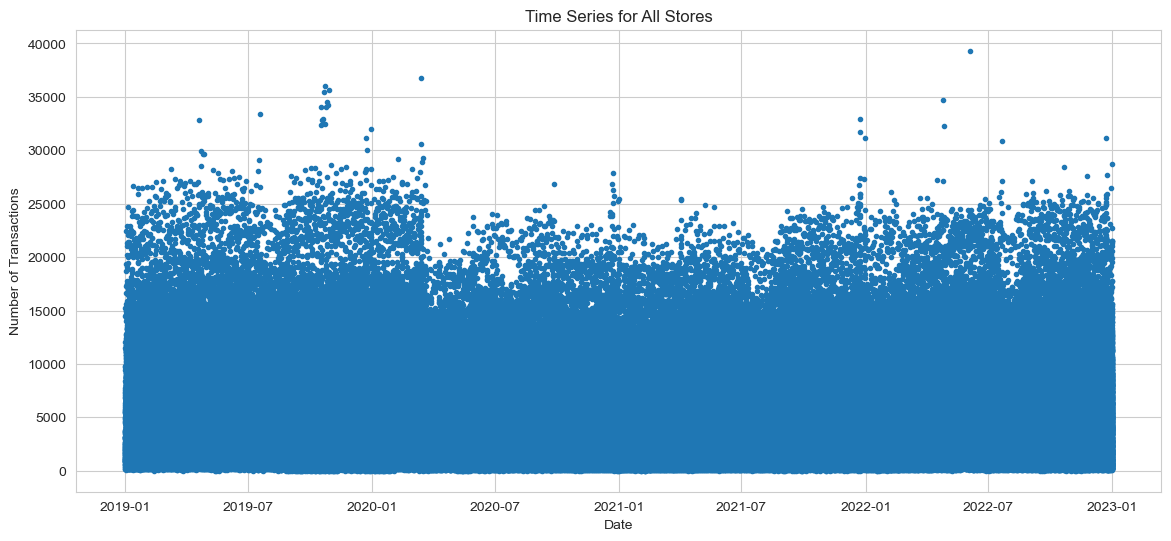

In [4]:
# Vizualize the time series per day for all stores
plt.figure(figsize=(14, 6))
plt.plot(data['sales_date'], data['n_transactions'], marker='.', linestyle='None')
plt.title('Time Series for All Stores')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()


## Trend Analysis per day

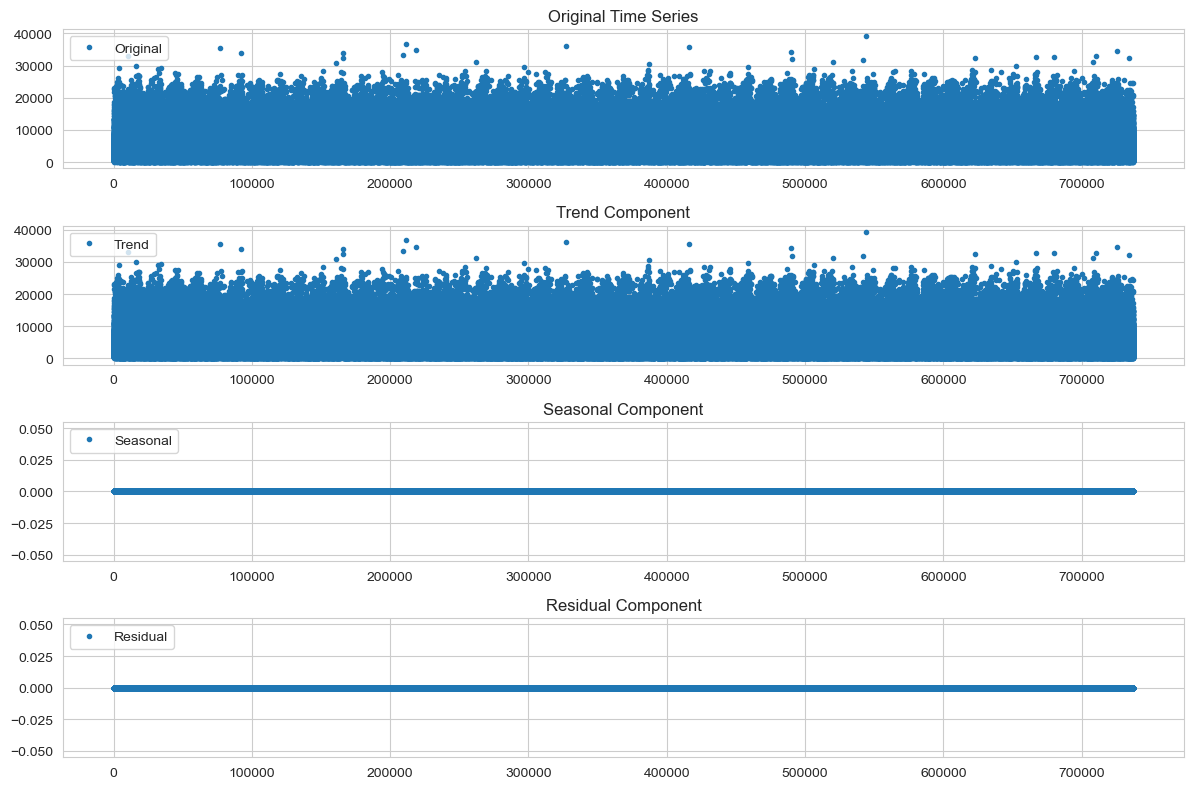

In [5]:
decomposition = seasonal_decompose(data['n_transactions'], model='additive', period=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['n_transactions'], marker='.', linestyle='None', label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(trend, label='Trend', marker='.', linestyle='None')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal', marker='.', linestyle='None')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual, label='Residual', marker='.', linestyle='None')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


From the plots above we can see that there is no clear trend or seasonality in the data.

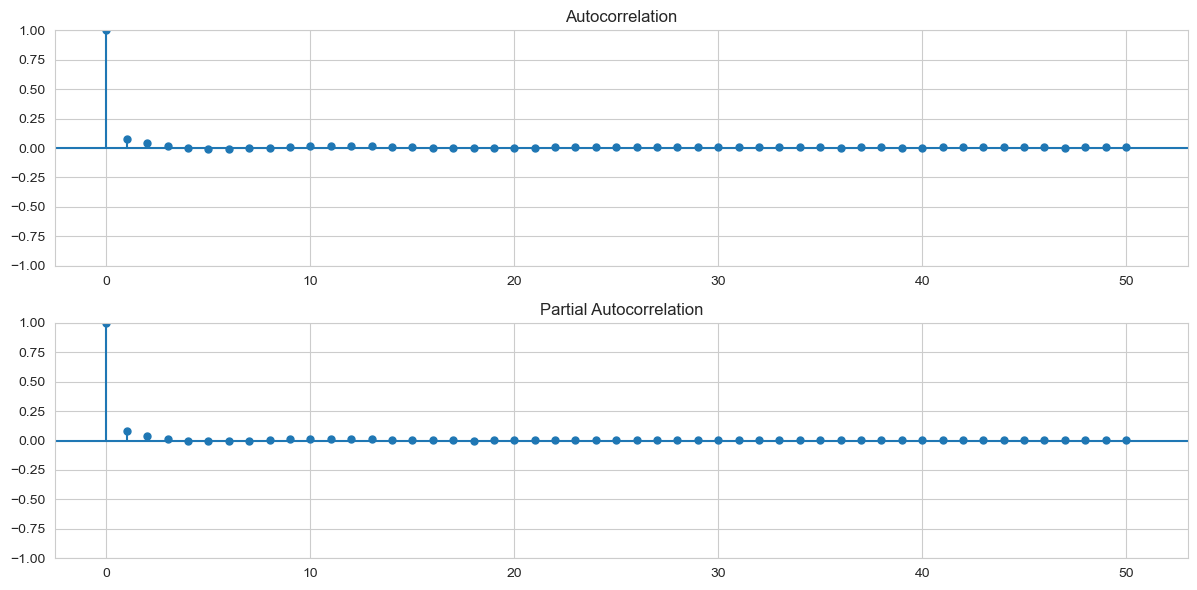

In [6]:
# Plot autocorrelation and partial autocorrelation
plt.figure(figsize=(12, 6))

plt.subplot(211)
plot_acf(data['n_transactions'], lags=50, ax=plt.gca())
plt.title('Autocorrelation')

plt.subplot(212)
plot_pacf(data['n_transactions'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation')

plt.tight_layout()
plt.show()


Both plots exhibit consistently low values close to zero for both autocorrelation and partial correlation, suggesting a lack of significant temporal dependence in the time series data and weak direct relationships between variables in the dataset.

## Vizualize the Time Series per day for all stores

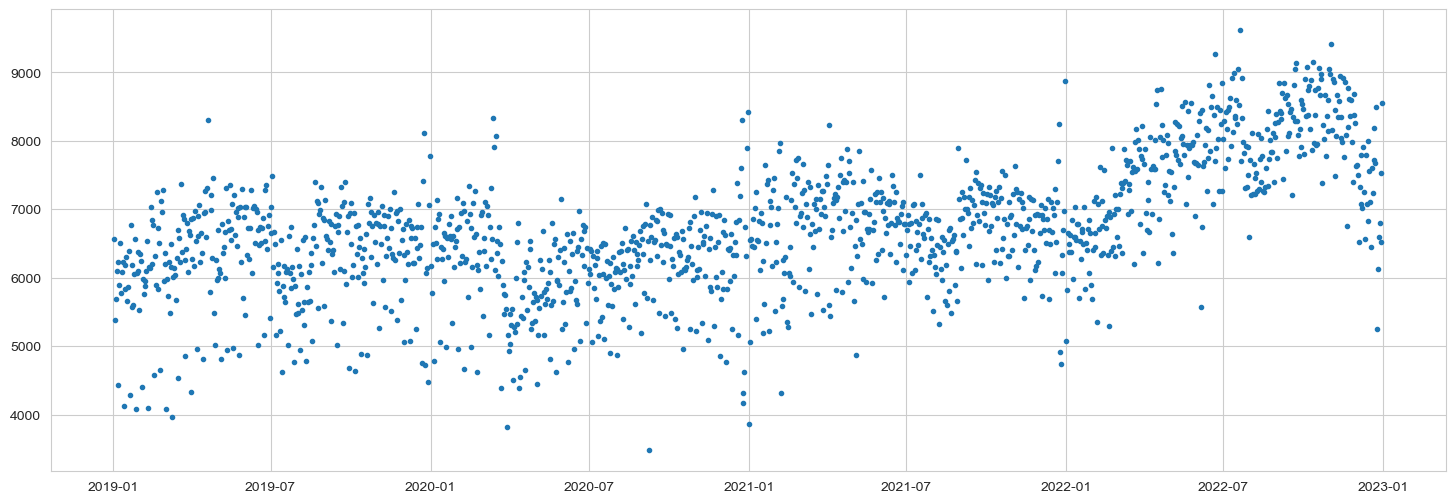

In [7]:
# Time Series Plot for all unique stores: Filter data for a specific store (replace 'store_id' with your desired store id)
unique_stores = data['store_hashed'].unique()

plt.figure(figsize=(18, 6))

for store_id in unique_stores:
    data = data[data['store_hashed'] == store_id]
    plt.plot(data['sales_date'], data['n_transactions'],  marker='.', linestyle='None', label=f'Actual - Store {store_id}')
    
plt.show()


# Time Series Forecasting
We want to forecast the number of n_transactions per day per store up to 50 days ahead.

### Prophet Model

In [15]:
# Load the preprocessed dataset
data = pd.read_parquet('n_forecast_preprocessed.parquet', engine='pyarrow', dtype_backend='numpy_nullable')


store_forecasts = {}
store_mapes = {} 
unique_stores = data['store_hashed'].unique()


for store_id in unique_stores:
    store_data = data[data['store_hashed'] == store_id]
    
    # Rename columns as per Prophet's requirements
    store_data = store_data.rename(columns={'sales_date': 'ds', 'n_transactions': 'y'})
    
    model = Prophet()
    model.fit(store_data)
    
    # Create a dataframe for future dates (50 days ahead)
    future = model.make_future_dataframe(periods=50)
    forecast = model.predict(future)
    
    # Evaluation
    actual_values = store_data['y'].values
    predicted_values = forecast['yhat'][:-50].values  # Exclude the future predictions
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    store_forecasts[store_id] = forecast
    store_mapes[store_id] = mape


16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:27 - cmdstanpy - INFO - Chain [1] done processing
16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing
16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1]

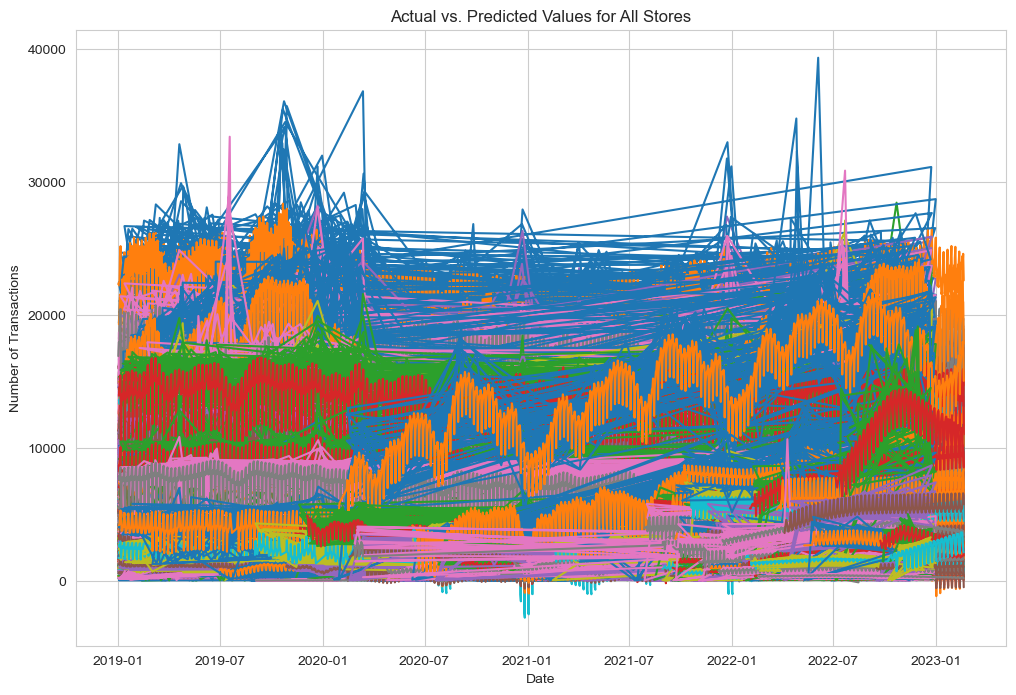

In [16]:
# Plot the actual vs. predicted values for all stores
plt.figure(figsize=(12, 8))

for store_id, forecast in store_forecasts.items():
    # Get the actual data for the current store
    actual_data = data[data['store_hashed'] == store_id]
    
    # Plot actual values
    plt.plot(actual_data['sales_date'], actual_data['n_transactions'], label=f'Actual - Store {store_id}')

    # Plot predicted values
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Predicted - Store {store_id}')

plt.title('Actual vs. Predicted Values for All Stores')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
# plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Calculate and print MAPE for each store
for store_id, mape in store_mapes.items():
    print(f'MAPE for Store {store_id}: {mape:.2f}%')

MAPE for Store b9d487a30398d42ecff55c228ed5652b: 14.54%
MAPE for Store c3e0c62ee91db8dc7382bde7419bb573: 21.28%
MAPE for Store 90db9da4fc5414ab55a9fe495d555c06: 9.51%
MAPE for Store 07042ac7d03d3b9911a00da43ce0079a: 11.90%
MAPE for Store b60c5ab647a27045b462934977ccad9a: 51.96%
MAPE for Store 90e1357833654983612fb05e3ec9148c: 35.78%
MAPE for Store f5c3dd7514bf620a1b85450d2ae374b1: 19.70%
MAPE for Store 4496bf24afe7fab6f046bf4923da8de6: 16.24%
MAPE for Store 57c0531e13f40b91b3b0f1a30b529a1d: 46.03%
MAPE for Store a09e75c5c86a7bf6582d2b4d75aad615: 18.90%
MAPE for Store 7f5fc754c7af0a6370c9bf91314e79f4: 22.46%
MAPE for Store 27669f3f141da48bfe5e6b7aa37c38f9: 17.60%
MAPE for Store 9ca8c9b0996bbf05ae7753d34667a6fd: 17.37%
MAPE for Store 7cce53cf90577442771720a370c3c723: 33.85%
MAPE for Store 144a3f71a03ab7c4f46f9656608efdb2: 24.64%
MAPE for Store cb8acb1dc9821bf74e6ca9068032d623: 13.33%
MAPE for Store faafda66202d234463057972460c04f5: 34.19%
MAPE for Store 86d7c8a08b4aaa1bc7c599473f5dddda: 

In [18]:
# print the average MAPE
print(f'\nAverage MAPE for All Stores: {np.mean(list(store_mapes.values())):.2f}%')


Average MAPE for All Stores: 32.24%


An average Mean Absolute Percentage Error (MAPE) of 32.24% for all stores indicates that, on average, the forecasts or predictions made have an error of approximately 32.24% when compared to the actual values. In practical terms, it implies that the forecasting model, on average, tends to deviate from the actual outcomes by about 32.24%, which suggests room for improvement in forecasting accuracy.

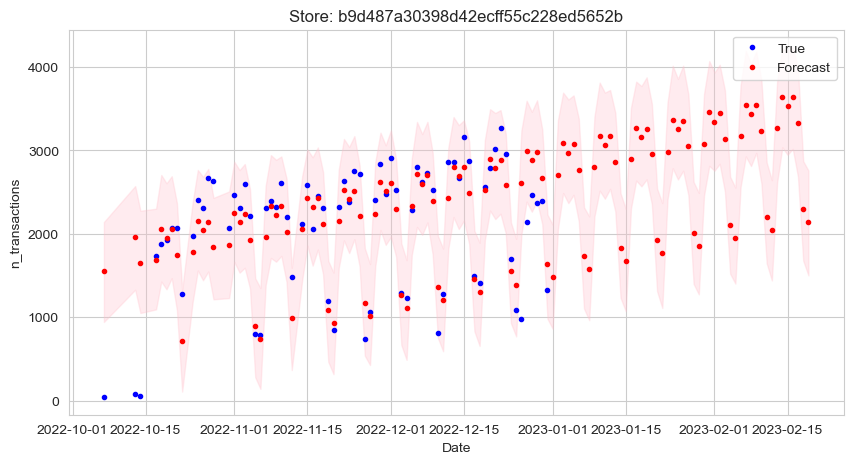

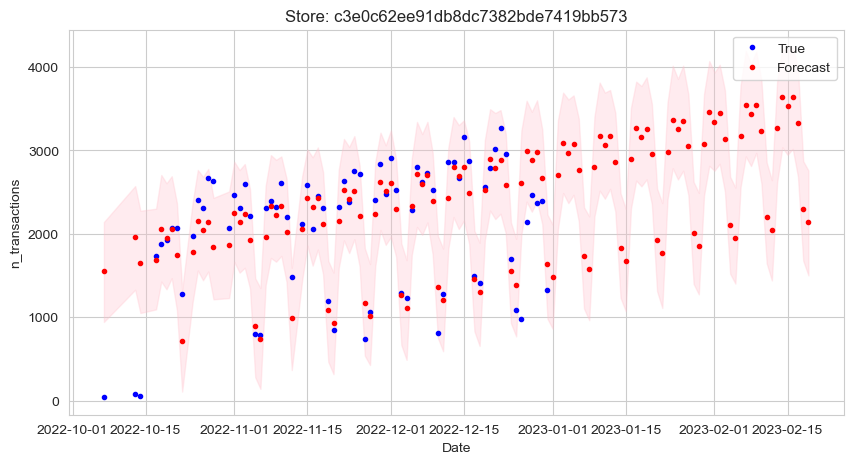

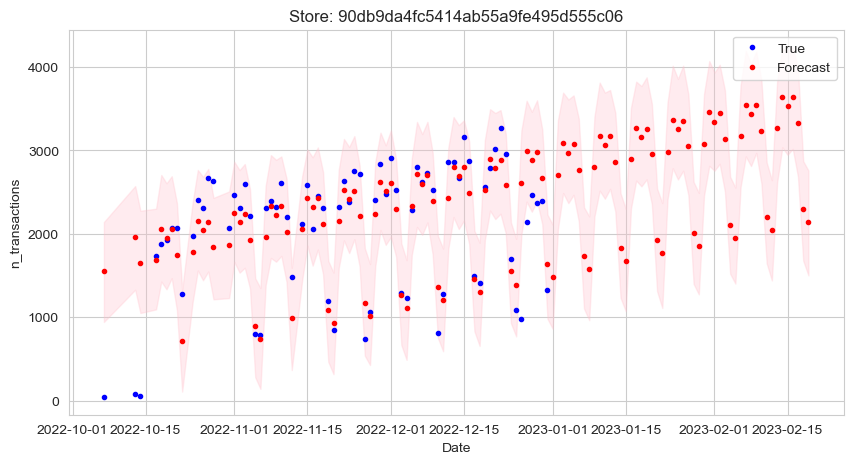

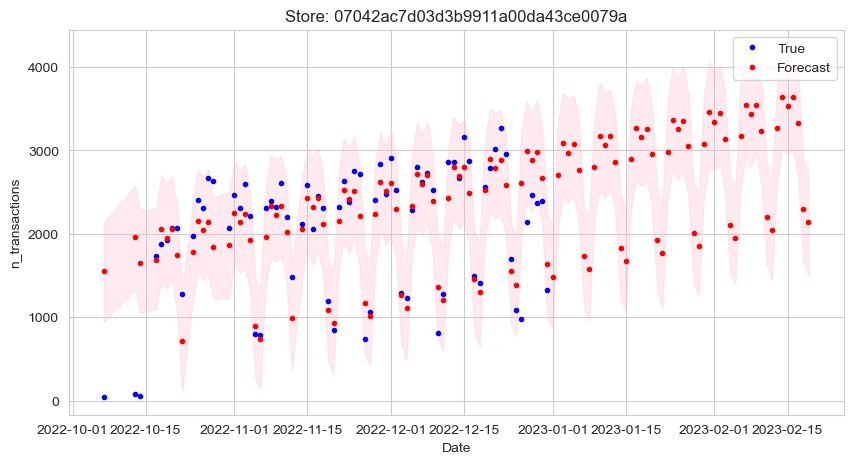

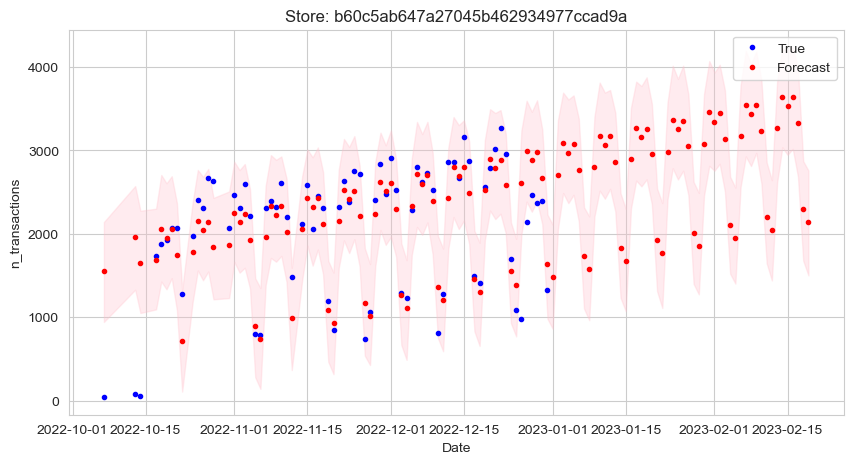

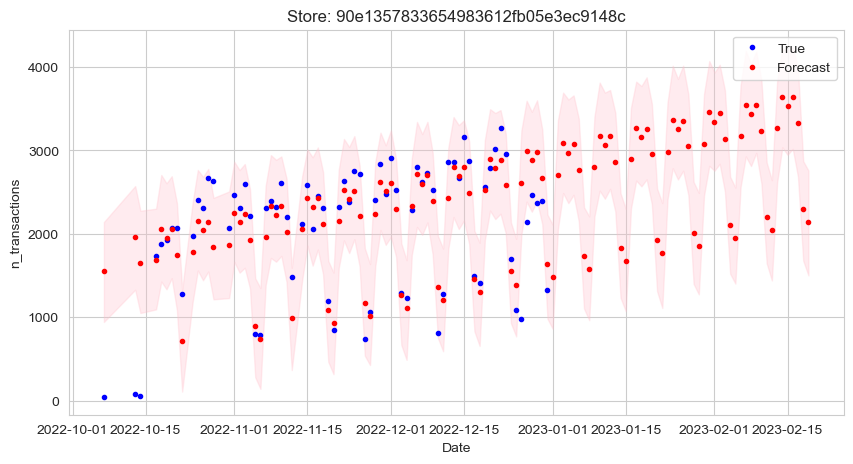

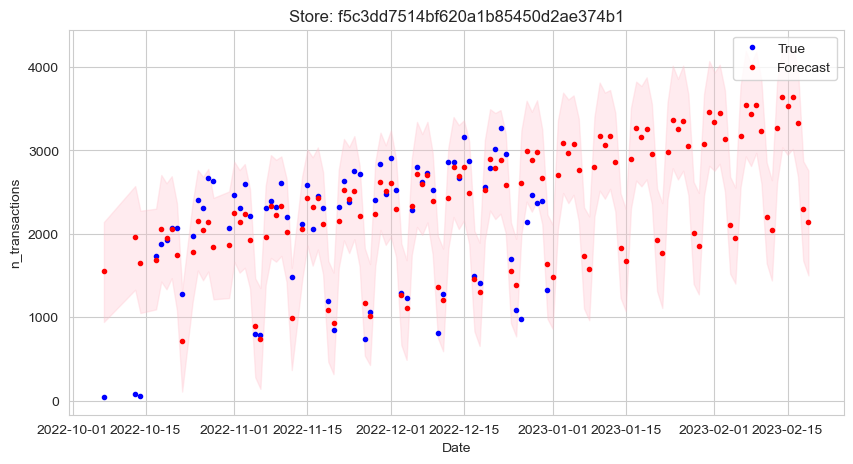

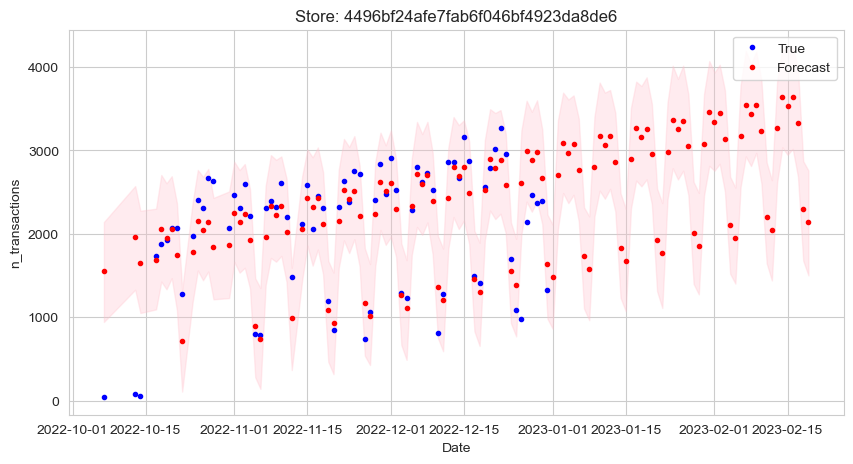

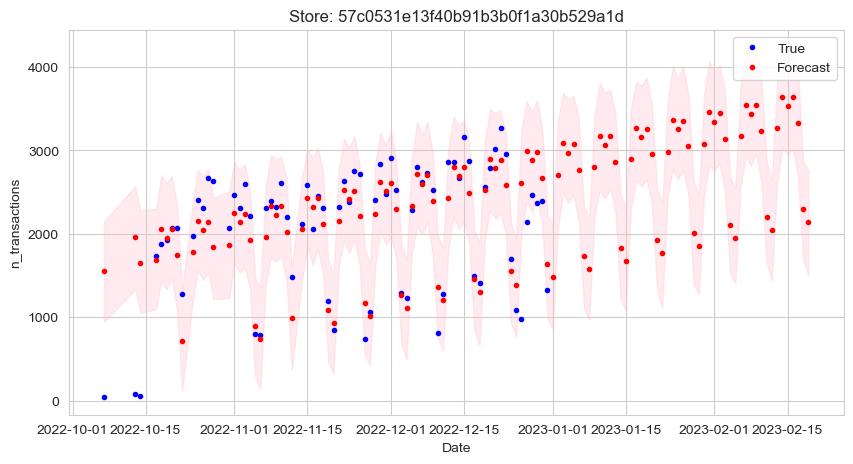

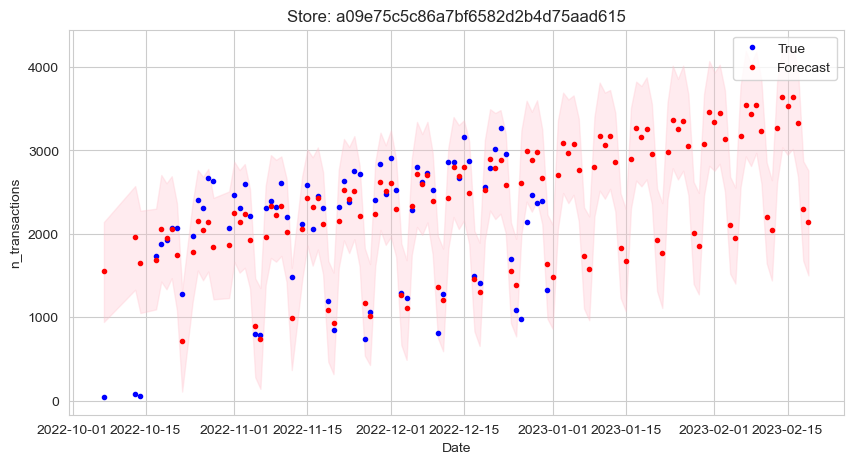

In [23]:
# Function to plot true vs. forecasted values
def plot_forecast(store, forecast):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(store['ds'], store['y'], marker='.', linestyle='None', label='True', color='blue')
    ax.plot(forecast['ds'], forecast['yhat'], marker='.',  linestyle='None', label='Forecast', color='red')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    ax.set_xlabel('Date')
    ax.set_ylabel('n_transactions')
    ax.set_title(f'Store: {store_name}')
    ax.legend()
    plt.show()


# We can also plot the forecasts for each store
for store_name in unique_stores[:10]:
    plot_forecast(store_data, forecast)